# ABC calibration of $I_\text{Na}$ in Nygren model using unified dataset.

In [1]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

INFO:myokit:Loading Myokit version 1.29.1


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for unified dataset calibration:
 - Steady-state activation [Sakakibara1992]
 - Activation time constant [Schneider1994]
 - Steady-state inactivation [Sakakibara1992]
 - Inactivation time constant (fast+slow) [Sakakibara1992]
 - Recovery time constant (fast+slow) [Sakakibara1992]

In [4]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin,
                                        sakakibara_rec)
from experiments.ina_schneider import schneider_taum

Load the myokit modelfile for this channel.

In [5]:
modelfile = 'models/nygren_ina.mmt'

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                schneider_taum,
                                                sakakibara_inact,
                                                sakakibara_inact_kin,
                                                sakakibara_rec)
assert len(observations)==len(summary_statistics(model({})))

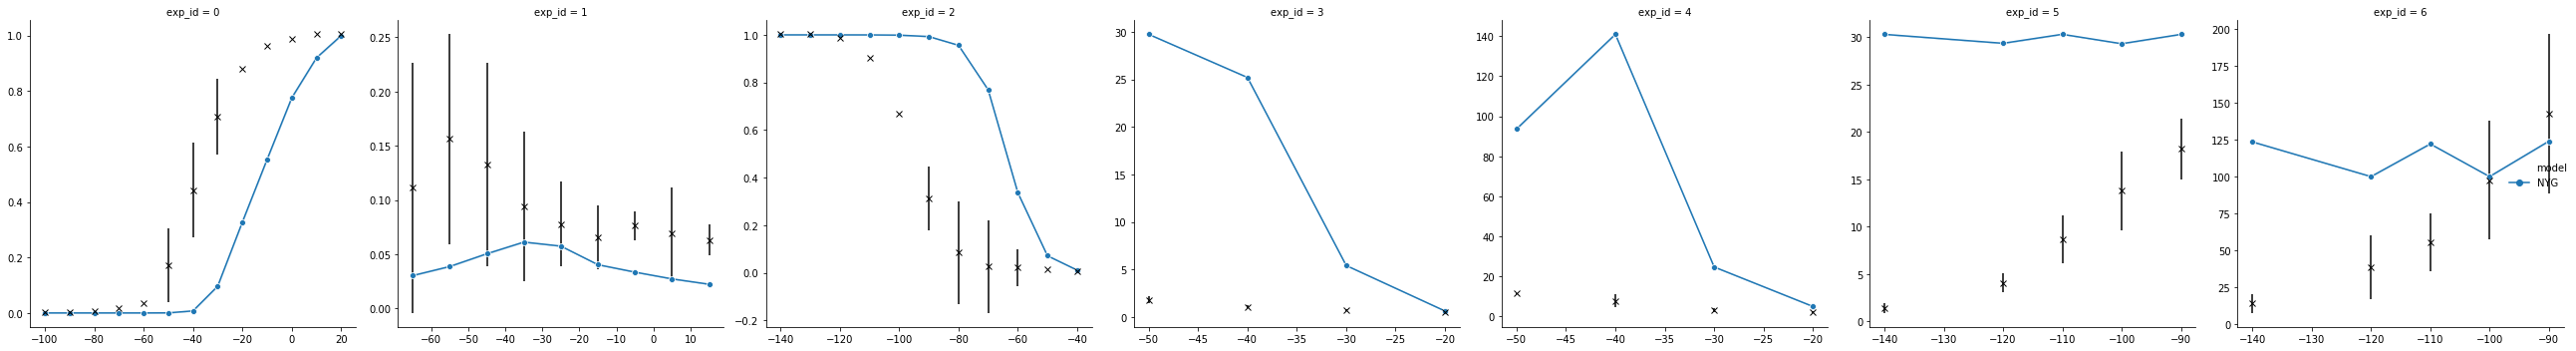

In [7]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     sakakibara_inact_kin,
                     sakakibara_rec)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [8]:
limits = {'ina.s1': (0, 1),
          'ina.r1': (0, 100),
          'ina.r2': (0, 20),
          'ina.q1': (0, 200),
          'ina.q2': (0, 20),
          'log_ina.r3': (-6, -3),
          'ina.r4': (0, 100),
          'ina.r5': (0, 20),
          'log_ina.r6': (-6, -3),
          'log_ina.q3': (-3., 0.),
          'ina.q4': (0, 100),
          'ina.q5': (0, 20),
          'log_ina.q6': (-5, -2),
          'log_ina.q7': (-3., 0.),
          'log_ina.q8': (-4, -1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [9]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

## Run ABC-SMC inference

Set-up path to results database.

In [10]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ina_unified.db"))

In [11]:
# Add logging for additional information during run.
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32768 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9521382851835398, '1': 0.9521382851835398, '2': 0.9521382851835398, '3': 0.9521382851835398, '4': 0.9521382851835398, '5': 0.3610802157587068, '6': 0.28091899218602906, '7': 0.34916236031070585, '8': 0.9521382851835398, '9': 0.9521382851835398, '10': 0.9521382851835398, '11': 0.9521382851835398, '12': 0.9521382851835398, '13': 0.09316342544404478, '14': 0.11125161472106906, '15': 0.11495918910006203, '16': 0.15597691589531334, '17': 0.27468055746289666, '18': 0.3630417376464485, '19': 0.8062952607338584, '20': 0.2544213362366676, '21': 0.7664744141929603, '22': 1.1252543370350925, '23': 1.1252543370350925, '24': 1.1252543370350925, '25': 1.1252543370350925, '26': 1.1252543370350925, '27': 0.42207751211772393, '28': 0.2622965124637598, '29': 0.2905205191839746, '30': 0.7247875556726021, '31': 1.1252543370350925, '32': 1.1252543370350925, '33': 0.808383669750957, '34': 1.591505349822196, '35': 2.2142683127961, '36': 3.0944494268465044, '37': 3.09444

In [14]:
# Convert observations to dictionary format for calibration
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2020-01-17 10:45:54.269253, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t: 0, eps: 20.
DEBUG:ABC:Now submitting population 0.


## Analysis of results

In [17]:
history = History(db_path)

In [18]:
history.all_runs()

[<ABCSMC(id=1, start_time=2020-01-17 10:42:51.689311, end_time=None)>,
 <ABCSMC(id=2, start_time=2020-01-17 10:45:54.269253, end_time=2020-01-22 21:49:21.644536)>]

In [19]:
df, w = history.get_distribution(m=0)

In [20]:
df.describe()

name,ina.q1,ina.q2,ina.q4,ina.q5,ina.r1,ina.r2,ina.r4,ina.r5,ina.s1,log_ina.q3,log_ina.q6,log_ina.q7,log_ina.q8,log_ina.r3,log_ina.r6
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,93.609110,8.666680,53.545999,10.384198,43.942824,12.557296,56.433300,9.834745,0.486514,-2.120397,-3.517956,-1.961741,-3.260629,-4.758479,-4.014764
std,3.453675,3.220605,2.615023,1.690733,6.368038,3.661292,25.348746,5.397284,0.197248,0.402762,0.559475,0.409539,0.394973,0.714048,0.126817
min,80.925429,0.695455,42.096723,4.898760,22.152524,0.835610,0.007547,0.000452,0.060662,-2.695190,-4.999213,-2.646660,-3.999937,-5.999718,-4.511262
25%,91.366510,6.319698,51.725281,9.216354,39.355183,10.005589,37.143746,5.310600,0.327840,-2.454938,-3.871622,-2.435968,-3.629969,-5.328492,-4.101912
50%,93.878064,8.461641,53.563724,10.463672,43.942885,12.646198,58.514136,9.919195,0.481958,-2.385128,-3.580028,-1.693734,-3.180823,-4.807415,-4.017395
75%,96.187867,10.869696,55.370946,11.569544,48.466190,15.297796,77.493422,14.222313,0.637485,-1.651643,-2.988101,-1.614620,-2.907450,-4.242267,-3.931070
max,103.917870,19.697700,62.719456,15.491809,64.848181,19.999272,99.997750,19.999197,0.942774,-1.443892,-2.518016,-1.462614,-2.495648,-3.001143,-3.529357


### Plot summary statistics compared to calibrated model output.

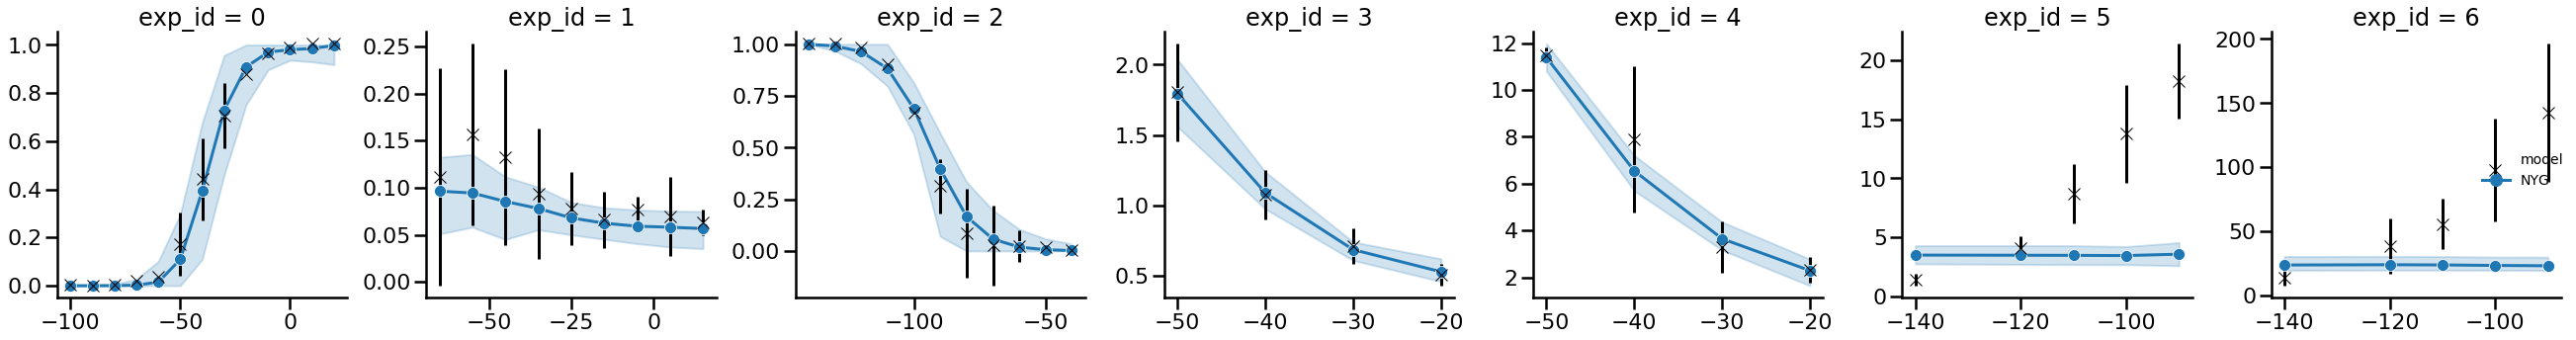

In [21]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     sakakibara_inact_kin,
                     sakakibara_rec,
                     df=df, w=w)

plt.tight_layout()

In [22]:
#g.savefig('figures/ina/nyg_unified_sum_stats.pdf')

### Plot parameter distributions

In [23]:
m,_,_ = myokit.load(modelfile)

In [24]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

In [25]:
limits.keys()

dict_keys(['ina.s1', 'ina.r1', 'ina.r2', 'ina.q1', 'ina.q2', 'log_ina.r3', 'ina.r4', 'ina.r5', 'log_ina.r6', 'log_ina.q3', 'ina.q4', 'ina.q5', 'log_ina.q6', 'log_ina.q7', 'log_ina.q8'])

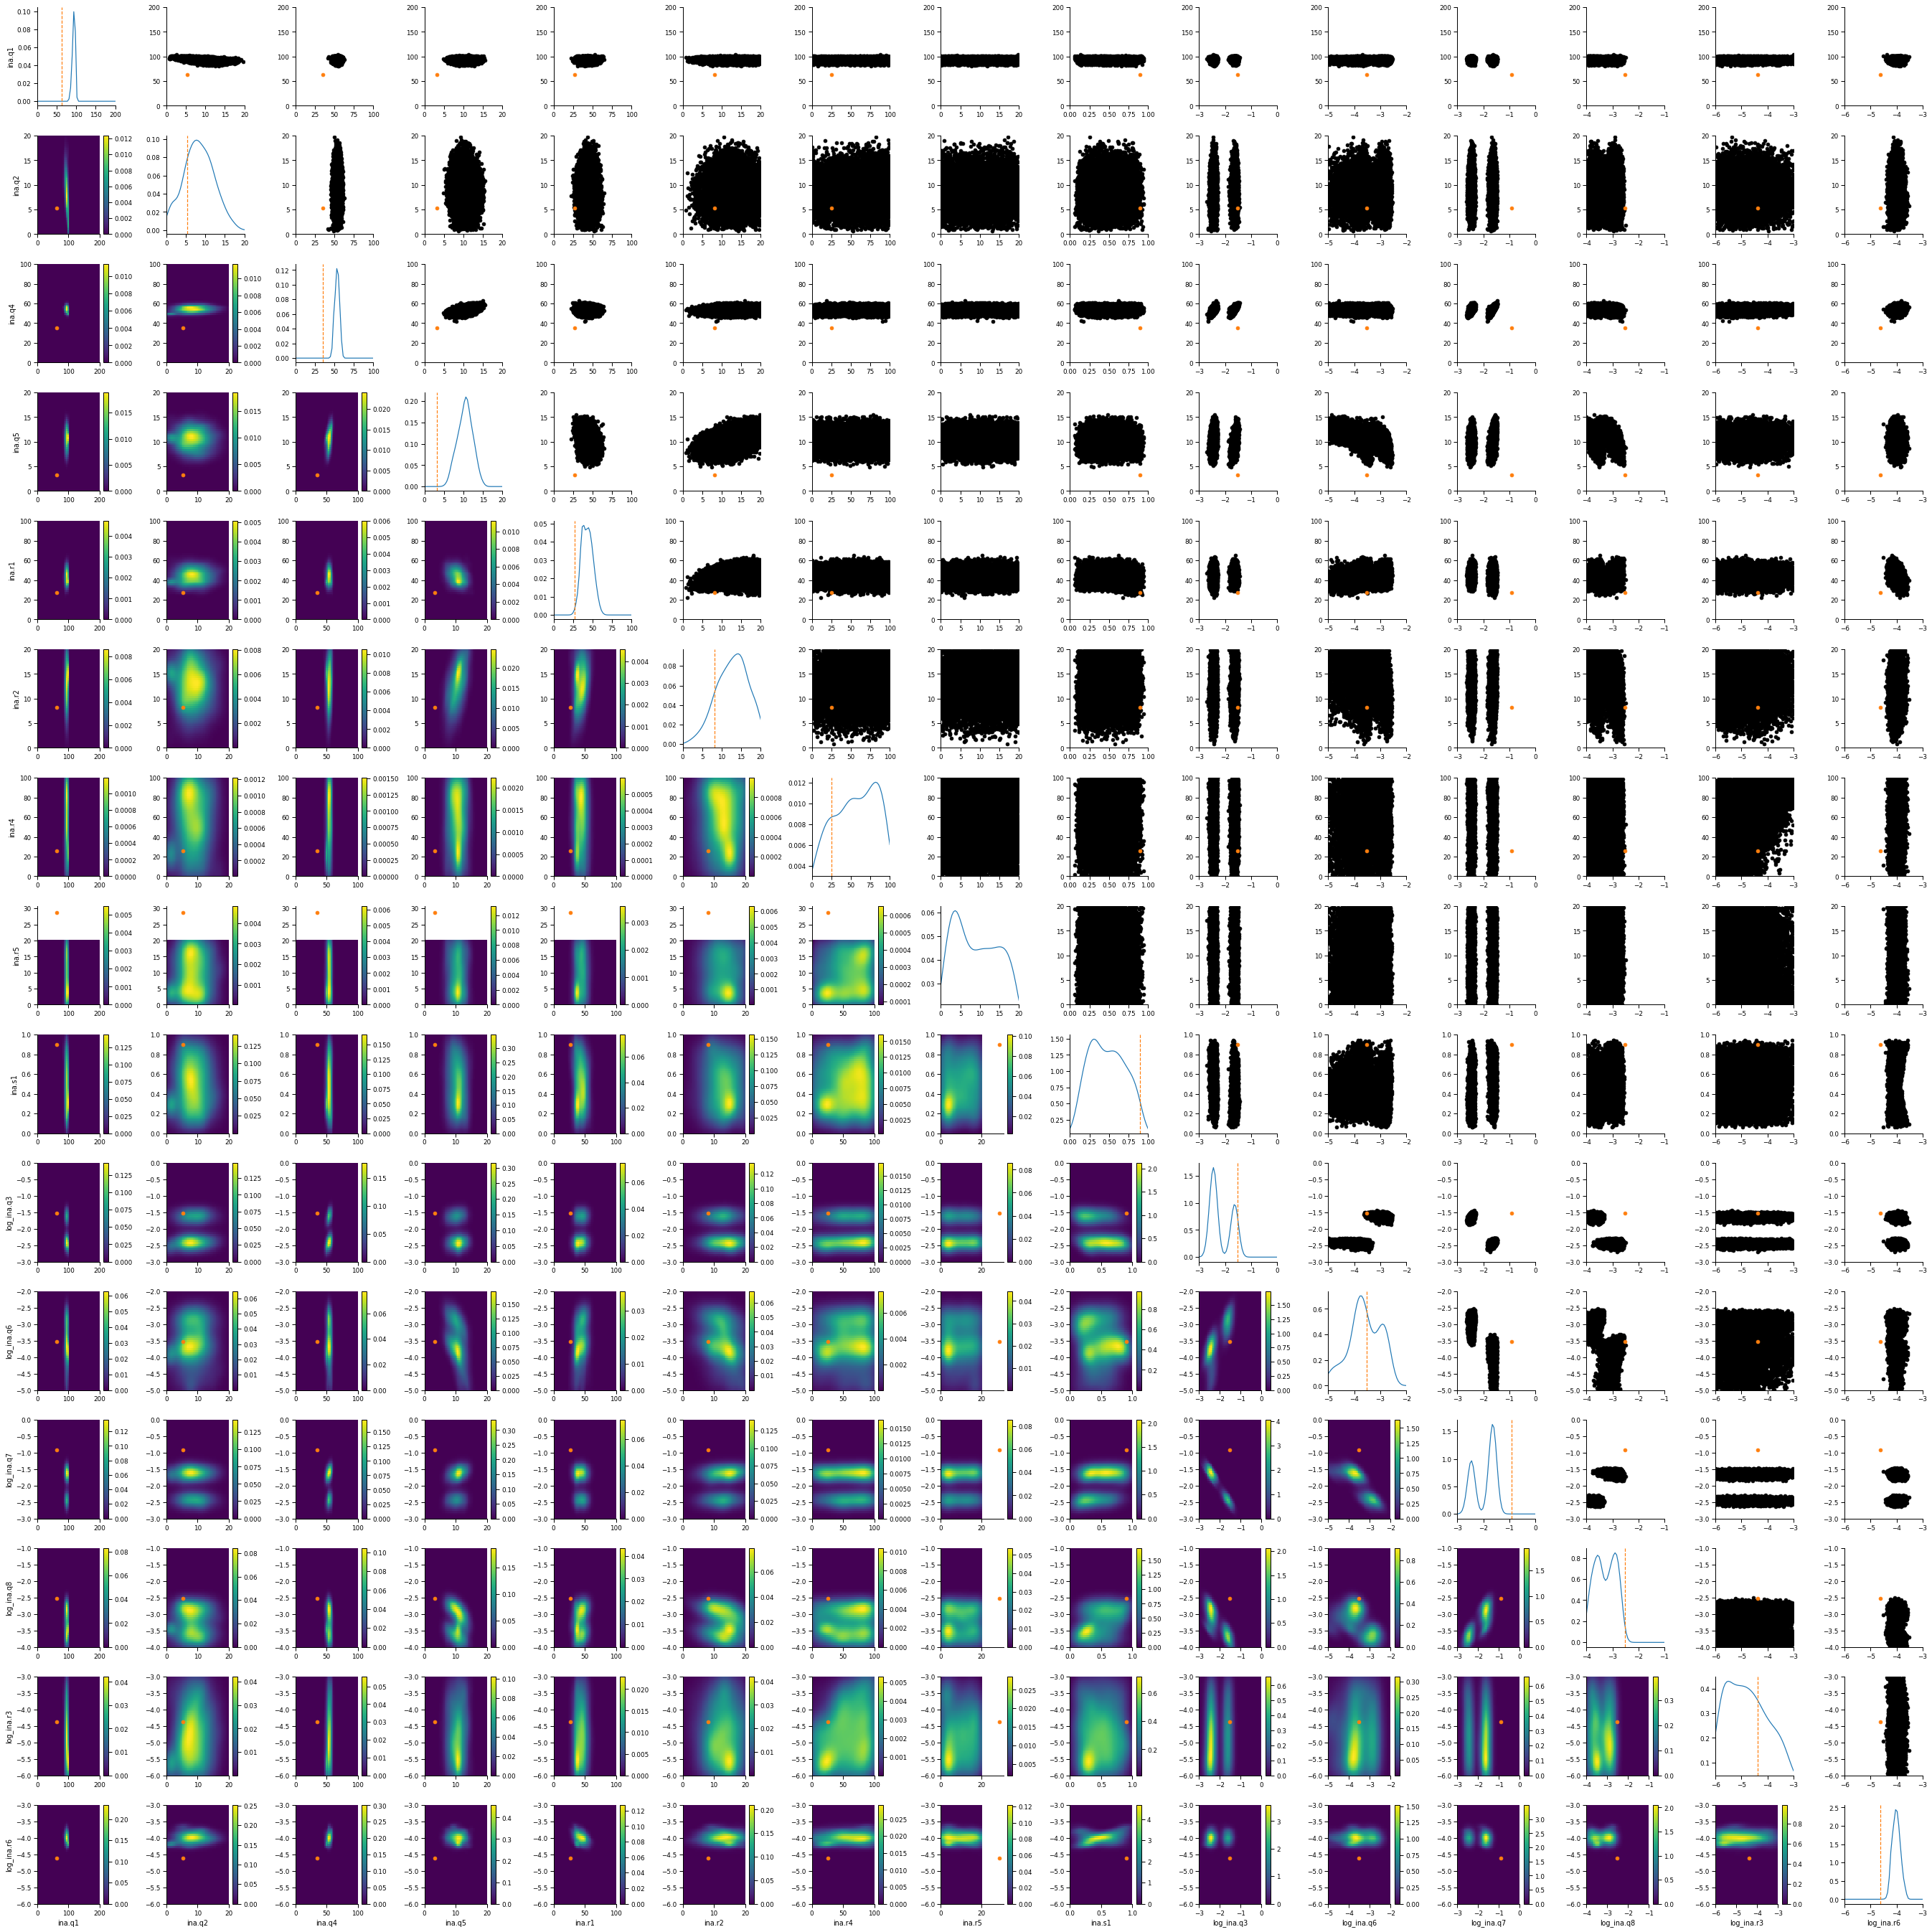

In [26]:
sns.set_context('paper')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)